In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import models, layers, metrics, optimizers, losses, regularizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint
import xarray as xr
import numpy as np 
import pandas as pd
import random

#### Function and Metrics

In [ ]:
METRICS = [
    metrics.CategoricalAccuracy(name='accuracy'),
    metrics.Precision(class_id = 1, name='precision'),
    metrics.Recall(class_id = 1, name='recall'),
    metrics.AUC(curve='PR', num_thresholds=1000, name='pr_auc')
]

def class_weights(x):
    n_class = x.max() + 1
    csize = []
    for i in range(n_class):
        csize.append((x == i).sum())
    w = dict()
    for i in range(n_class):
        w[i] = max(csize)/(csize[i]*n_class)
    return(w)
    
def onehot(x):
    y = np.zeros((x.size, x.max()+1)) 
    y[np.arange(x.size),x] = 1
    
    return(y)

#### Data preparation

In [ ]:
data_x=xr.open_dataset('../input_data/Vertical_Integrated_Moisture_convergence.nc')
data_y=pd.read_csv('../processed_data/extreme_event_days.csv')
data_y['time'] = pd.to_datetime(data_y['time'], errors='coerce')
data_y=data_y.drop('Unnamed: 0', axis=1)
n_time=len(data_x.time.values)
n_lat=len(data_x.lat.values)
n_lon=len(data_x.lon.values)
x_data=data_x.VIMFC.values
x_data=(x_data-x_data.mean(axis=0))/x_data.std(axis=0)
x_data=x_data.reshape(n_time, n_lat, n_lon, 1).astype(np.float32)
y_data=np.array(data_y['label'])
y_data=y_data.astype(np.int32)
y_data_one_hot=onehot(y_data)
ind = np.arange(len(y_data))
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x_data, y_data_one_hot, ind, test_size=0.20, random_state=42, 
                                                                         shuffle = True, stratify = y_data_one_hot)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

#### Training model with best model from Hyper_Turning

In [40]:
def build_model(lr=0.0001, conv_filters = 16, dense_neurons =32, dense_layers = 1, activity_reg = 0.0001, dropout_rate = 0.2, input_channels = 1):

    model = models.Sequential() 
    model.add(layers.Input(shape=(121, 121, input_channels))) 
    
    model.add(layers.Conv2D(conv_filters, (3,3), activity_regularizer=regularizers.l2(activity_reg))) 
    model.add(layers.Activation('relu')) 
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(dropout_rate))
                            
    model.add(layers.Conv2D(conv_filters, (3,3), activity_regularizer=regularizers.l2(activity_reg))) 
    model.add(layers.Activation('relu')) 
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(dropout_rate))
                            
    model.add(layers.Flatten()) 
    
    for i in range(dense_layers):
        model.add(layers.Dense(dense_neurons, activity_regularizer=regularizers.l2(activity_reg)))
        model.add(layers.Activation('relu'))
     
    model.add(layers.Dense(2, activation='softmax')) 
    
    model.compile(loss=losses.CategoricalCrossentropy(), 
                  optimizer=optimizers.Adam(learning_rate = lr), 
                  metrics=METRICS)
    return(model)

#### Model training

In [41]:
y_labels = np.argmax(y_data_one_hot, axis=1)
y_weight = y_labels[ind_train]
class_weigh = class_weights(y_weight.astype('int'))
model = build_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 119, 119, 16)      160       
                                                                 
 activation_12 (Activation)  (None, 119, 119, 16)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 59, 59, 16)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 59, 59, 16)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 57, 57, 16)        2320      
                                                                 
 activation_13 (Activation)  (None, 57, 57, 16)        0         
                                                      

In [42]:
history = model.fit(x_train, y_train, batch_size = 2048, epochs = 100, class_weight = class_weigh, 
                    validation_data = (x_test, y_test), callbacks = [callback])

Epoch 1/100
6/6 [==============================] - 8s 1s/step - loss: 3.9642 - accuracy: 0.7985 - precision: 0.2307 - recall: 0.7580 - pr_auc: 0.9060 - val_loss: 3.8801 - val_accuracy: 0.4685 - val_precision: 0.1127 - val_recall: 0.9155 - val_pr_auc: 0.4545
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 3.7463 - accuracy: 0.5799 - precision: 0.1300 - recall: 0.8388 - pr_auc: 0.5795 - val_loss: 3.5688 - val_accuracy: 0.8368 - val_precision: 0.2591 - val_recall: 0.6667 - val_pr_auc: 0.9055
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 3.5752 - accuracy: 0.7406 - precision: 0.1959 - recall: 0.8271 - pr_auc: 0.7800 - val_loss: 3.4620 - val_accuracy: 0.7823 - val_precision: 0.2319 - val_recall: 0.8592 - val_pr_auc: 0.8525
Epoch 4/100
6/6 [==============================] - 7s 1s/step - loss: 3.4162 - accuracy: 0.7888 - precision: 0.2361 - recall: 0.8518 - pr_auc: 0.8492 - val_loss: 3.2846 - val_accuracy: 0.8313 - val_precision: 0.2792 - val_reca

In [44]:
model.save_weights('../processed_data/trained_weight.h5')

In [45]:
test_loss, test_accuracy, test_precision, test_recall, test_pr_auc=model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")
print(f"Test AUC: {test_pr_auc * 100:.2f}%")

92/92 - 0s - loss: 0.7516 - accuracy: 0.9466 - precision: 0.6000 - recall: 0.8028 - pr_auc: 0.9898 - 406ms/epoch - 4ms/step
Test Accuracy: 94.66%
Test Precision: 60.00%
Test Recall: 80.28%
Test AUC: 98.98%


In [46]:
class_predictions = model.predict(x_data)

457/457 [==============================] - 2s 4ms/step


In [47]:
history_df = pd.DataFrame(history.history) 
history_df.to_csv('../processed_data/model_metrics.csv')
date=data_x.time.values
predict_df = pd.DataFrame(class_predictions)
predict_df = predict_df.rename(columns = {0: 'prob_0', 1: 'prob_1'})
predict_df['predicted_class'] = np.argmax(class_predictions, axis = 1)
predict_df['set'] = 'train'
predict_df.loc[ind_test, 'set'] = 'test'
predict_df['true_y'] = y_data
predict_df.insert(0, 'date', date)
predict_df.to_csv('../processed_data/model_predictions.csv')

In [55]:
evaluation=model.evaluate(x_data, y_data_one_hot, verbose=2)
evaluation
ev=pd.DataFrame({'loss':[evaluation[0]], 'accuracy': [evaluation[1]], 'precision': [evaluation[2]], 'recall':[evaluation[3]], 'pr_auc': [evaluation[4]],'lr':[0.0001], 'activity_reg':[0.0001], 'dropout_rate':[0.2]})
ev.to_csv('../processed_data/model_evaluation.csv')

457/457 - 2s - loss: 0.7278 - accuracy: 0.9612 - precision: 0.6627 - recall: 0.9501 - pr_auc: 0.9938 - 2s/epoch - 4ms/step


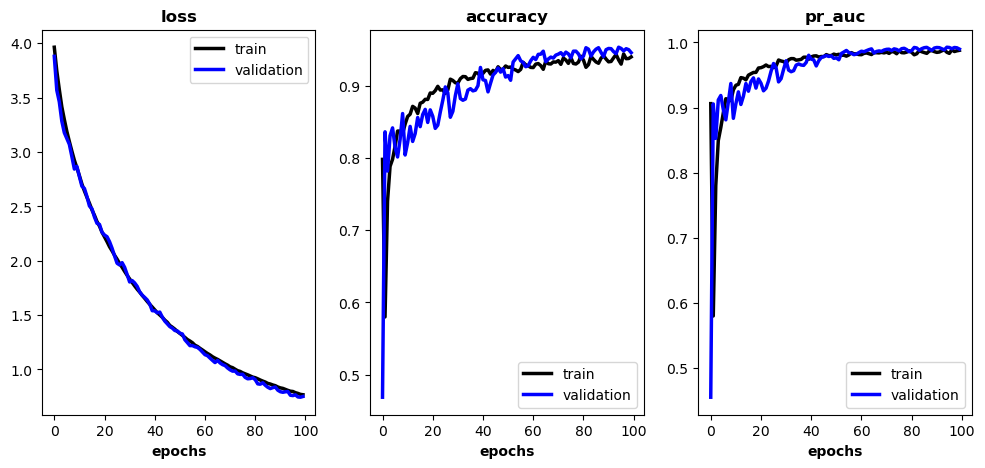

In [33]:
fig = plt.figure(figsize=(12, 5))
df=pd.read_csv('../processed_data/model_metrics.csv')
title=['loss', 'accuracy', 'recall']
metrics=['loss', 'accuracy', 'pr_auc']
val_metrics=['val_loss', 'val_accuracy', 'val_pr_auc']
for k in range(3):
    metric=df[metrics[k]]
    val_metric=df[val_metrics[k]]
    ax = fig.add_subplot(1, 3, k+1)
    ax.plot(metric, 'k', linewidth=2.5, label='train')
    ax.plot(val_metric, 'b', linewidth=2.5,   label='validation')
    ax.set_title(metrics[k], fontweight='bold')
    ax.set_xlabel('epochs', fontweight='bold')
    ax.legend()
plt.savefig('../figures/Figure01.jpg', bbox_inches='tight', pad_inches=0.1, format='jpg', dpi=600) 